<a href="https://colab.research.google.com/github/ottojvn/dio-ml/blob/main/DIO_ML_TransferLearning_Bikes_Horses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projeto para o curso Machine Learning Specialist da plataforma DIO

Este notebook utiliza transfer learning para treinar um modelo de Deep Learning que sabe diferenciar bicicletas de cavalos, para que você nunca mais tenha dificuldade de identificar um desses agentes.

In [49]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import keras.utils as image

from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Carrega o dataset e exclui as categorias não desejadas 

In [44]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/Colab\ Notebooks/DIO/data.zip /content/data.zip
!unzip data.zip
!rm data.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  data.zip
replace data/bike/bike_001.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [60]:
root = 'data'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)
for c, category in enumerate(categories):
  print(c)
  print(category)

['data/bike', 'data/horses']
0
data/bike
1
data/horses


Faz o pre-processamento das imagens

In [51]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carrega todas as imagens

In [61]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg','.bmp']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

# randomize data order
random.shuffle(data)

Cria um split de treinamento, validação e teste

In [62]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separa os dados para rotulos

In [63]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]


In [ ]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

In [65]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 567 images from 2 categories
train / validation / test split: 396, 85, 86
training data shape:  (396, 224, 224, 3)
training labels shape:  (396, 2)


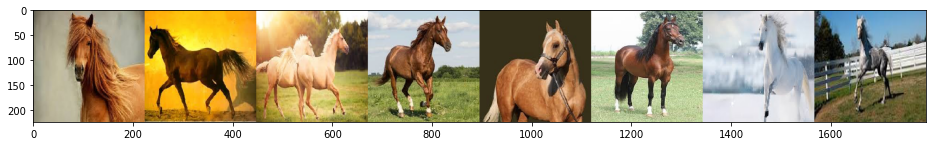

In [81]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Para servir de comparação primeiro é treinado um modelo de redes neurais do zero

In [82]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                   

In [83]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
4/4 [==============================] - 26s 6s/step - loss: 0.7470 - accuracy: 0.5455 - val_loss: 0.6774 - val_accuracy: 0.5059
Epoch 2/10
4/4 [==============================] - 23s 5s/step - loss: 0.6025 - accuracy: 0.6742 - val_loss: 0.6864 - val_accuracy: 0.5059
Epoch 3/10
4/4 [==============================] - 25s 5s/step - loss: 0.5355 - accuracy: 0.7096 - val_loss: 0.5763 - val_accuracy: 0.7059
Epoch 4/10
4/4 [==============================] - 23s 5s/step - loss: 0.4678 - accuracy: 0.8005 - val_loss: 0.4909 - val_accuracy: 0.8000
Epoch 5/10
4/4 [==============================] - 25s 6s/step - loss: 0.3807 - accuracy: 0.8434 - val_loss: 0.5234 - val_accuracy: 0.7647
Epoch 6/10
4/4 [==============================] - 24s 5s/step - loss: 0.2955 - accuracy: 0.8889 - val_loss: 0.3919 - val_accuracy: 0.8353
Epoch 7/10
4/4 [==============================] - 23s 5s/step - loss: 0.2857 - accuracy: 0.8990 - val_loss: 0.2351 - val_accuracy: 0.8941
Epoch 8/10
4/4 [==================

KeyError: ignored

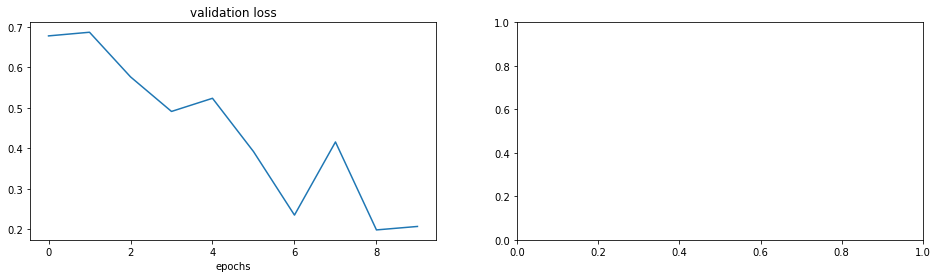

In [84]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [85]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.1657884567975998
Test accuracy: 0.9651162624359131


Utilizando o transfer learning com uma rede preexistente

In [86]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [87]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [88]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [89]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10
4/4 [==============================] - 228s 55s/step - loss: 0.8234 - accuracy: 0.6338 - val_loss: 0.8294 - val_accuracy: 0.5059
Epoch 2/10
4/4 [==============================] - 220s 54s/step - loss: 0.4696 - accuracy: 0.7298 - val_loss: 0.2748 - val_accuracy: 0.9529
Epoch 3/10
4/4 [==============================] - 221s 54s/step - loss: 0.2736 - accuracy: 0.9848 - val_loss: 0.1849 - val_accuracy: 0.9647
Epoch 4/10
4/4 [==============================] - 220s 54s/step - loss: 0.1817 - accuracy: 0.9318 - val_loss: 0.1386 - val_accuracy: 0.9647
Epoch 5/10
4/4 [==============================] - 220s 54s/step - loss: 0.1149 - accuracy: 0.9874 - val_loss: 0.0965 - val_accuracy: 0.9882
Epoch 6/10
4/4 [==============================] - 222s 54s/step - loss: 0.1016 - accuracy: 0.9949 - val_loss: 0.0771 - val_accuracy: 0.9882
Epoch 7/10
4/4 [==============================] - 219s 54s/step - loss: 0.0747 - accuracy: 0.9899 - val_loss: 0.0663 - val_accuracy: 0.9765
Epoch 8/10
4/4 [====

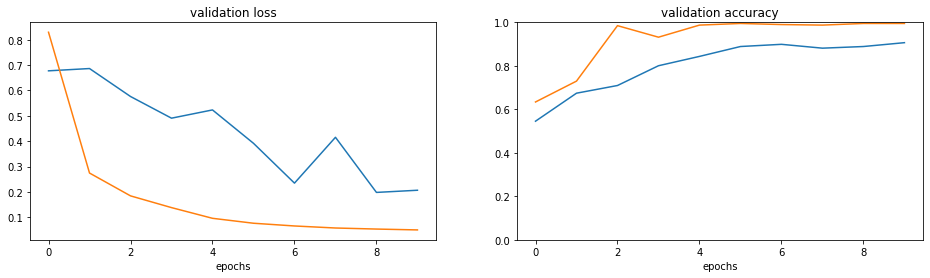

In [91]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"])
ax2.plot(history2.history["accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [101]:
!curl -L -o bike.png --progress-bar https://lasmagrelas.com.br/wp-content/uploads/2021/09/IMG_3598.png
img, x = get_image('bike.png')
probabilities = model_new.predict([x])
print(probabilities)


######################################################################## 100.0%
1/1 [==============================] - 1s 558ms/step
[[0.9637812  0.03621884]]
